#PROJECT 3

IMPORT PACKAGES

In [1]:
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

PRICE MOMENTUM FACTORS & IDENTIFYING LONG AND SHORT ASSETS

In [2]:
class momentum_factors:
    def __init__(self, spy_listings, tickers):
        self.price, self.volume = spy_listings["Adj Close"], spy_listings["Volume"]
        self.returns = self.price.pct_change()
        self.tickers = tickers

        self.momentumdf = pd.DataFrame(index=self.tickers)

    def trend(self, input_df):
        self.input_df = input_df
        self.trend_df = pd.DataFrame(index=self.tickers)

        for i in range(1, 21):
            self.trend_df[i] = np.polyfit(
                range(252),
                self.input_df[-i-252: -i],
                1,
            )[0]

        return self.trend_df.mean(axis=1)

    def price_momentumfactors(self):

        # Run 52-Wk Trend Func.
        self.momentumdf["trend"] = self.trend(input_df=self.price)

        # Percent Above
        self.roll_min = self.price.rolling(252).min()
        self.momentumdf["pct_above"] = ((self.price - self.roll_min) / self.roll_min)[-20:].mean()

        # Price Osc.
        self.rolling_260 = self.price.rolling(260)
        self.momentumdf["p_osc"] = (
            (self.price.rolling(20).mean() - self.rolling_260.mean()) /
            self.rolling_260.std()
        )[-20:].mean()

        # 39-Wk Ret.
        self.momentumdf["39_wk_ret"] = self.price.pct_change(189)[-20:].mean()

        # Price Vol. Trend
        self.price_volumedf = self.price * self.volume
        self.momentumdf["price_volume"] = self.trend(input_df=self.price_volumedf)

        return ((self.momentumdf - self.momentumdf.mean()) / self.momentumdf.std()).sum(axis=1)

    def baskets(self):
          self.momentumscore = self.price_momentumfactors()
          self.z_scored = self.momentumscore

          return self.z_scored.nlargest(10).index, self.z_scored.nsmallest(10).index


GATHERING SPY DATA

In [4]:
ssga = "https://www.ssga.com/us/en/individual/etfs/library-content/products/fund-data/etfs/us/holdings-daily-us-en-spy.xlsx"
spy_listings = list(pd.read_excel(ssga, header=4).Ticker.dropna())
data = yf.download(spy_listings, period="10y")
data = data.dropna(how="all", axis=1)
tickers = list(data["Adj Close"].columns)

[*********************100%***********************]  503 of 503 completed
ERROR:yfinance:
15 Failed downloads:
ERROR:yfinance:['VLTO', 'KVUE']: YFInvalidPeriodError("%ticker%: Period '10y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', 'ytd', 'max']")
ERROR:yfinance:['AMTM']: YFInvalidPeriodError("%ticker%: Period '10y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', 'ytd', 'max']")
ERROR:yfinance:['SW']: YFInvalidPeriodError("%ticker%: Period '10y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']")
ERROR:yfinance:['-', 'BRK.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")')
ERROR:yfinance:['ABNB', 'OTIS', 'CEG', 'CARR', 'PLTR', 'GEHC']: YFInvalidPeriodError("%ticker%: Period '10y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', 'ytd', 'max']")
ERROR:yfinance:['SOLV', 'GEV']: YFInvalidPeriodError("%tick

BACKTESTING

In [8]:
backtestlngth = 5
end = dt.datetime.today()
start = end - dt.timedelta(365.25 * backtestlngth)
freq = "M"
hist_rets = data['Adj Close'].pct_change().resample('M').sum().shift(-1)
rangendtes = pd.DataFrame(pd.date_range('2018-12-01', dt.datetime.today(), freq ='M'))
rangendtes.rename (columns = {0: 'date'}, inplace = True)
longreturn, shortreturn = pd.DataFrame(), pd.DataFrame()

for date in rangendtes.date:
    MF = momentum_factors(data[data.index <= date], tickers)
    longbasket, shrtbasket = MF.baskets()

    longreturn = pd.concat([longreturn, hist_rets.loc[[date], longbasket]])
    shortreturn = pd.concat([shortreturn, hist_rets.loc[[date], shrtbasket]])


<ipython-input-8-8ab414e7fe3e>:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  hist_rets = data['Adj Close'].pct_change().resample('M').sum().shift(-1)
<ipython-input-8-8ab414e7fe3e>:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rangendtes = pd.DataFrame(pd.date_range('2018-12-01', dt.datetime.today(), freq ='M'))
<ipython-input-2-298a08810e16>:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  self.returns = self.price.pct_change()
<ipython-input-2-298a08810e16>:39: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

VISUALIZATIONS

[*********************100%***********************]  1 of 1 completed
<ipython-input-9-fbb36199f26b>:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  spy_monthly_returns = spy_data["Adj Close"].pct_change().resample("M").sum()


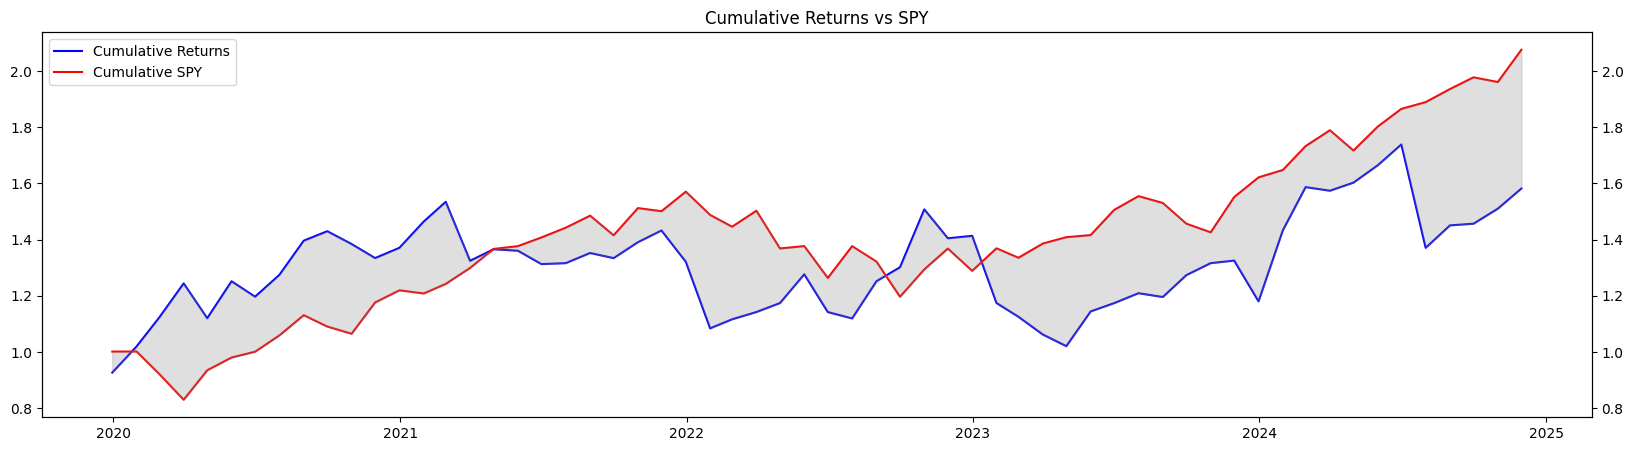

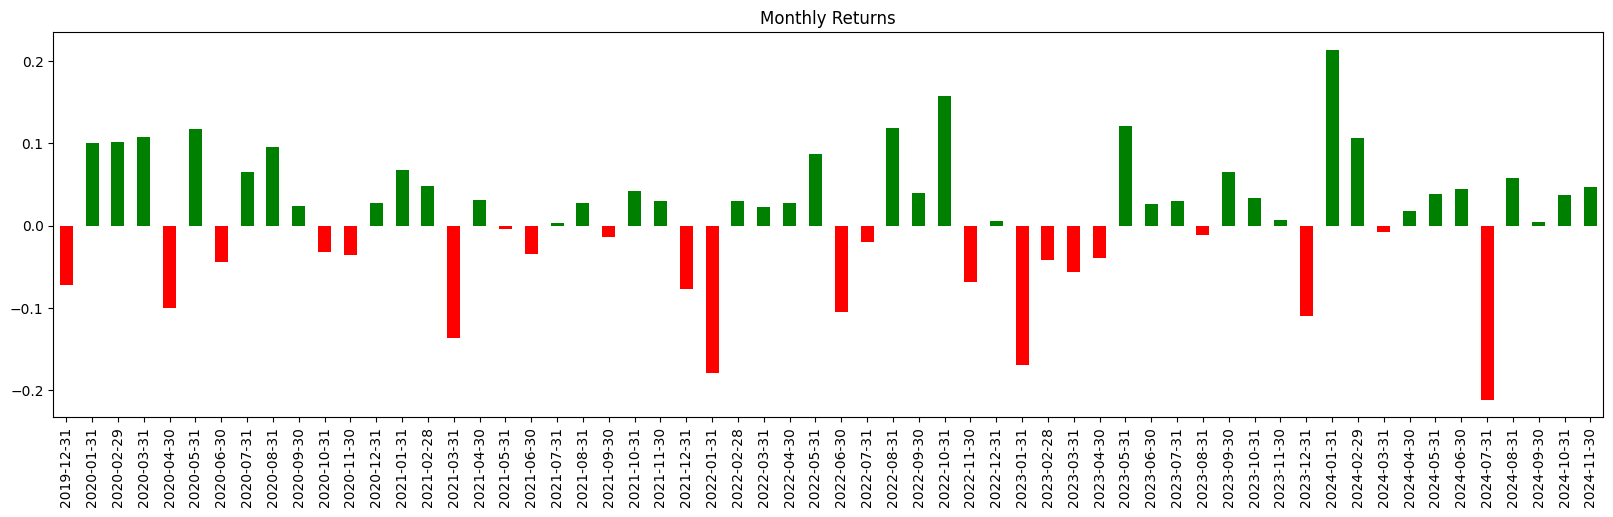

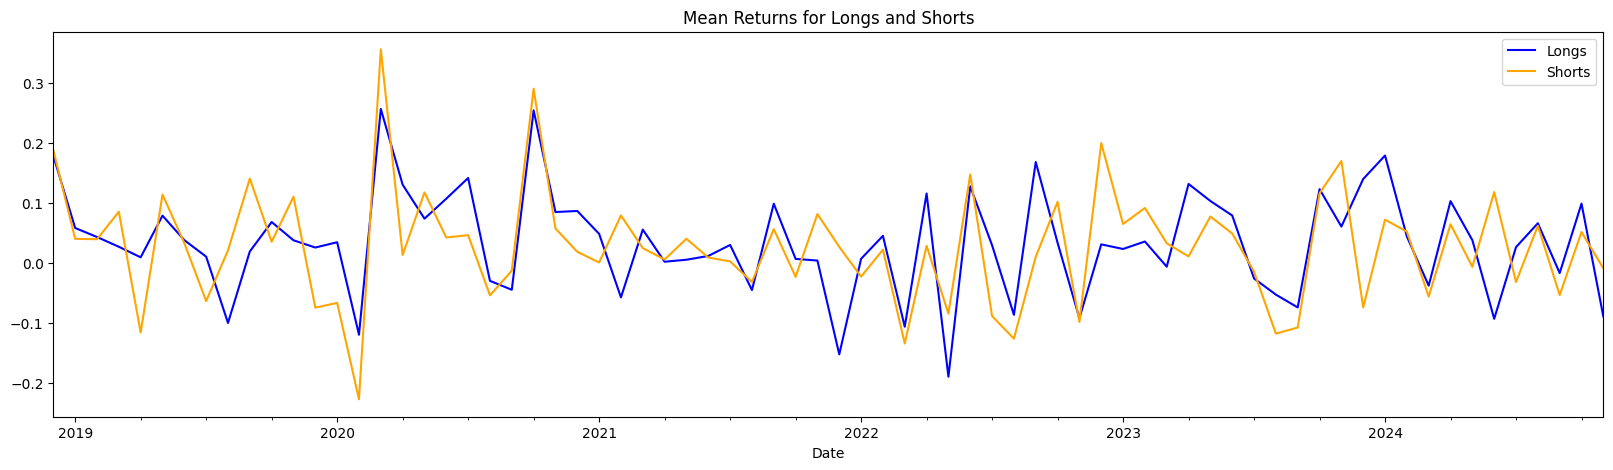

In [9]:

# Calculate Total Returns
tottsretrns = pd.DataFrame((longreturn.mean(axis=1) - shortreturn.mean(axis=1)).shift(), columns=["tottsretrns"])
tottsretrns = tottsretrns[-60:]

# GRAPH 1: Cumulative Returns and Comparison with SPY
# Calculate cumulative returns
tottsretrns["cum_ret"] = np.exp(np.log1p(tottsretrns["tottsretrns"]).cumsum())

# Fetch and calculate SPY cumulative returns
spy_data = yf.download("SPY", period="5y")
spy_monthly_returns = spy_data["Adj Close"].pct_change().resample("M").sum()
tottsretrns["spy"] = spy_monthly_returns

tottsretrns["cum_spy"] = np.exp(np.log1p(tottsretrns["spy"].fillna(0)).cumsum())

# Calculate additional metrics
tottsretrns["pos"] = tottsretrns["tottsretrns"] > 0
tottsretrns["cum_vs"] = tottsretrns["cum_ret"] - tottsretrns["cum_spy"]
tottsretrns["cum_pos"] = tottsretrns["cum_vs"] > 0

# Convert index to date
tottsretrns.index = tottsretrns.index.date

# Plot cumulative returns
figure, ax1 = plt.subplots(figsize=(20, 5))
ax2 = ax1.twinx()

x = tottsretrns.index
ax2.fill_between(x, tottsretrns["cum_ret"], tottsretrns["cum_spy"], alpha=0.25, color="gray")
ax1.plot(x, tottsretrns["cum_ret"], label="Cumulative Returns", color="blue")
ax1.plot(x, tottsretrns["cum_spy"], label="Cumulative SPY", color="red")

ax1.legend(loc="upper left")
plt.title("Cumulative Returns vs SPY")
plt.show()

# GRAPH 2: Bar Plot of Total Returns with Positive/Negative Coloring
figure, ax2 = plt.subplots(figsize=(20, 5))
tottsretrns["tottsretrns"].plot(
    kind="bar",
    color=tottsretrns["pos"].map({True: "green", False: "red"}),
    ax=ax2
)

plt.title("Monthly Returns")
plt.show()

# GRAPH 3: Mean Returns for Longs and Shorts
figure, ax = plt.subplots(figsize=(20, 5))
longreturn.mean(axis=1).plot(label="Longs", color="blue", ax=ax)
shortreturn.mean(axis=1).plot(label="Shorts", color="orange", ax=ax)

plt.legend()
plt.title("Mean Returns for Longs and Shorts")
plt.show()
